# Assignment 2 - Predictive Process Monitoring

**Due: Friday, 19 December, 2025 at 17:00 CET**

In this assignment, you will learn to train a regression model to predict the remaining time of a process. Additionally, you will demonstrate your ability to evaluate the model's performance and discuss the results in a report. The learning objectives of this assignment are to:

- Apply data cleaning, data transformation, and feature encoding techniques to preprocess event data.
- Use regression models to predict the remaining time of ongoing cases.
- Calculate model performance metrics (e.g., MAE, MSE, RMSE, \(R^2\), etc.).
- Refine the experimental design to compare the performance of different preprocessing and encoding methods.
- Reflect on the differences between various methods and their effect on the model performance.


## Tasks Overview

This assignment includes six tasks:

1. **Data Exploration:** Perform data exploration to understand the dataset.
2. **Data Preprocessing and Trace Encoding:** Apply data preprocessing and trace encoding (covered during Lectures 5 and 7).
3. **Regression Model Training:** Select a regression algorithm of interest and train a regression model (a regressor) to forecast the remaining time of each case after each event (see Lecture 6)
4. **Prefix-Length Buckets:** Create buckets of different prefix lengths and train a separate regressor for each bucket (covered during Lectures 5 and 7).
5. **Alternative Methods:** Revisit your design decisions and investigate two additional methods that may improve model performance.
6. **Evaluation:** Evaluate the results.

### Notes

- You may reuse your code from Tasks 2 and 3 in Assignment 1 for Tasks 4 and 5.
- For Task 6 and your report, ensure that you save all the calculated metrics (MAE, MSE, RMSE, and \(R^2\)) in previous tasks. Save these metrics in a list or dictionary to facilitate easy evaluation and comparison of results.




## Task 1: Exploring the data set



### Data set: Sepsis

Import the file *Complete Sepsis.csv* to load the Sepsis data set. This real-life event log contains events of sepsis cases from a hospital. Sepsis is a life threatening condition typically caused by an infection. One case represents a patient's pathway through the treatment process. The events were recorded by the ERP (Enterprise Resource Planning) system of the hospital. The original data set contains about 1000 cases with in total 15,000 events that were recorded for 16 different activities. Moreover, 39 data attributes are recorded, e.g., the group responsible for the activity, the results of tests and information from checklists. 

Additional information about the data can be found :
- https://data.4tu.nl/articles/dataset/Sepsis_Cases_-_Event_Log/12707639
- http://ceur-ws.org/Vol-1859/bpmds-08-paper.pdf




### Information about the dataset

The dataset used in this assignment is an event log, which records the execution of multiple process instances (cases). In this context, each case represents a patient suspected of having sepsis. The log captures the sequence of clinical activities performed for each patient, where each activity corresponds to a specific diagnostic or treatment-related test. The associated timestamp indicates when the activity was executed.

The data mining phase has already been completed. The subsequent objective is to develop predictive models capable of estimating the remaining time of an ongoing case. Specifically, given a newly admitted patient and the set of clinical events recorded so far, the goal is to predict the expected duration of the patient’s hospitalization based on the progression of diagnostic tests and treatments.

In [169]:
# packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [118]:
# import data   
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', False)
data_Sepsis = pd.read_csv("./Complete_Sepsis_Filtered.csv", sep=";")

In [119]:
# create an overview of the data
rows, columns = data_Sepsis.shape[0], data_Sepsis.shape[1]
print(f"Amount of rows: {rows}\nAmount of features: {columns}")
# print(data_Sepsis.shape)

# all column names
columns = [col for col in data_Sepsis.columns]
print(f"\nList of columns: {columns}")

# all unique activities
uniq_activities = [activity for activity in data_Sepsis["Activity"].unique()]
print(f"List of all unique activities in col Activity: {uniq_activities}")
print(f"Amount of unique activities: {len(uniq_activities)}")

# all unique cases (Patients) in hospital
uniq_patients = [patient for patient in data_Sepsis['Case ID'].unique()]
print(f"\nTotal unique patients: {len(uniq_patients)}")

Amount of rows: 13042
Amount of features: 32

List of columns: ['Case ID', 'Activity', 'Complete Timestamp', 'lifecycle:transition', 'org:group', 'InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'Age', 'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid', 'Diagnose', 'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG', 'Leucocytes', 'CRP', 'LacticAcid']
List of all unique activities in col Activity: ['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Release A', 'Admission IC', 'Release B', 'Release C', 'Release D', 'Release E']
Amount of unique activities: 15

Total unique patients: 777


In [120]:
# datatypes of variables
datatypes = data_Sepsis.dtypes

# only three features contain purely floats, while some rows contain NaN as well
float_cols = data_Sepsis.select_dtypes(include=["float64"]).columns
print(f"These variables are of the datatype float: {list(float_cols)}")

# all labeled as object, while lifecycle:transition: str, 'org:group': str, 'Diagnose': str
object_cols = data_Sepsis.select_dtypes(include=['object']).columns
print(f"These variables are of the datatype object: {list(object_cols[3:])}")

These variables are of the datatype float: ['Age', 'Leucocytes', 'CRP', 'LacticAcid']
These variables are of the datatype object: ['lifecycle:transition', 'org:group', 'InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid', 'Diagnose', 'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG']


### Features that only contain: True, False or NaN

In [121]:
# rest is semantically Boolean, this means that they are not Boolean yet. 
bool_like_cols = [
    'InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg',
    'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion',
    'DiagnosticArtAstrup', 'DiagnosticIC', 'DiagnosticSputum',
    'DiagnosticLiquor', 'DiagnosticOther', 'SIRSCriteria2OrMore',
    'DiagnosticXthorax', 'SIRSCritTemperature',
    'DiagnosticUrinaryCulture', 'SIRSCritLeucos', 'Oligurie',
    'DiagnosticLacticAcid', 'Hypoxie', 'DiagnosticUrinarySediment',
    'DiagnosticECG'
]

for col in bool_like_cols:
    print(col, data_Sepsis[col].dropna().unique())

InfectionSuspected [True False]
DiagnosticBlood [True False]
DisfuncOrg [True False]
SIRSCritTachypnea [True False]
Hypotensie [True False]
SIRSCritHeartRate [True False]
Infusion [True False]
DiagnosticArtAstrup [True False]
DiagnosticIC [True False]
DiagnosticSputum [False True]
DiagnosticLiquor [False True]
DiagnosticOther [False True]
SIRSCriteria2OrMore [True False]
DiagnosticXthorax [True False]
SIRSCritTemperature [True False]
DiagnosticUrinaryCulture [True False]
SIRSCritLeucos [False True]
Oligurie [False True]
DiagnosticLacticAcid [True False]
Hypoxie [False True]
DiagnosticUrinarySediment [True False]
DiagnosticECG [True False]


In [122]:
# mean, max, min activities per case
events_per_case = data_Sepsis.groupby("Case ID").size()

print(events_per_case.describe())

count    776.000000
mean      16.775773
std       12.140095
min        5.000000
25%       12.000000
50%       14.000000
75%       17.000000
max      185.000000
dtype: float64


In [123]:
# frequency of each age, seeing upwards trend
age_counts_df = data_Sepsis["Age"].value_counts(dropna=True).reset_index()
age_counts_df.columns = ["Age", "Count"]

# for loop calculating percentage of ages   
total = 0
percentage = []
for count in age_counts_df["Count"]:
    total += count
    percentage.append(count/777 * 100)
    
age_counts_df['Percentage'] = percentage

i = 0
for percentage in age_counts_df['Percentage'][0:6]: 
    i += percentage
    
print(i)

74.77477477477477


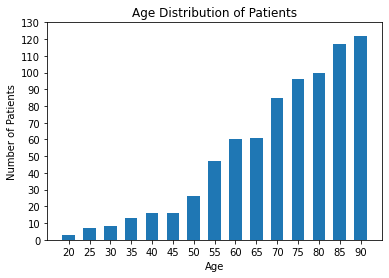

In [124]:
fig, ax = plt.subplots()

# Plot
ax.bar(age_counts_df["Age"], age_counts_df["Count"], width=3)

# Axis labels
ax.set_xlabel("Age")
ax.set_ylabel("Number of Patients")
ax.set_title("Age Distribution of Patients")

# Age axis ticks every 5 years
ax.set_xticks(range(int(age_counts_df["Age"].min()),
                   int(age_counts_df["Age"].max()) + 1, 5))

# Frequency axis ticks every 10
ax.set_yticks(range(0, age_counts_df["Count"].max() + 10, 10))

plt.show()

### Create the Labels by Calculating the Remaining Time

To forecast the remaining time for each patient in the hospital, we group the events by patient, use the completion time of each patient (i.e., the timestamp of the last event for each patient), and calculate the time difference between the current event and the completion time. This is done for each event. As a result, we now have our labels, which indicate how long a patient will remain in the treatment process for each event.

To help you get started, we created the target variable *remaining_time(days)* for you. 

In [125]:
df = data_Sepsis.copy()

# Convert the timestamp column to datetime
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])

# Find the completion time for each case
completion_times = df.groupby('Case ID')['Complete Timestamp'].max().rename('completion_time')

# Merge completion time back into the original DataFrame
df = df.merge(completion_times, on='Case ID')

# Calculate the remaining time for each event
df['remaining_time'] = df['completion_time'] - df['Complete Timestamp']

# Calculate the remaining time for each event in days
df['remaining_time(days)'] = df['remaining_time'].dt.total_seconds()/60/60/24

# Retain rows where the remaining time is larger than 0 days. 
df = df[df['remaining_time(days)'] > 0]

# Drop the completion_time column to avoid information leakage
df = df.drop(columns=['completion_time'])

# Drop the remaining_time column to avoid information leakage
df = df.drop(columns=['remaining_time'])

# Display the result
label_column = 'remaining_time(days)'
# print(df['remaining_time(days)'].describe())

# Fill in the column names of case id, activity, and time stamps
column_Sepsis_CaseID = 'Case ID' 
column_Sepsis_Activity = 'Activity'
column_Sepsis_Timestamps = 'Complete Timestamp'


### 1.1 Exploratory data analysis

For the data set, create 2-3 figures/tables that help you understand the data 

Note that some of these variables are categorical variables and some are numberical. Additionally, some of the variables have missing values. Think/discuss how would you preprocess these variables.


Make sure to at least check each variable's data type and understand their distribution. 

*For creating data visualizations, you may consider using the matplot library and visit the [matplot gallery](https://matplotlib.org/stable/gallery/index.html) for inspiration (e.g., histograms for distribution, or heatmaps for feature correlation).*


### Markdown added by me (Mart)
Note that some of these variables are categorical variables and some are numberical. Additionally, some of the variables have missing values. Think/discuss how would you preprocess these variables.

Many attributes in the Sepsis log contain NaN values. In this context, NaN does not indicate a missing measurement error but the fact that a diagnostic test was not performed at that point in the process. This absence is clinically meaningful and must therefore be preserved. Consequently, these attributes will be treated as categorical three-level variables (True / False / Not performed), rather than being imputed or discarded.

Make sure to at least check each variable's data type and understand their distribution - All the variables data types have been outputted above.

### Figure 1 — Distribution of Remaining Time Across Events

This plot shows how many events occur at different remaining times (measured in days). Most events happen when the remaining time is still very short (0–10 days), and the frequency quickly drops as the remaining time increases. The long tail on the right indicates that a few patients stay in the process much longer than the rest.

This skewed distribution is important because it tells us that predicting long remaining times will be harder for the model, simply because these cases are much less common.

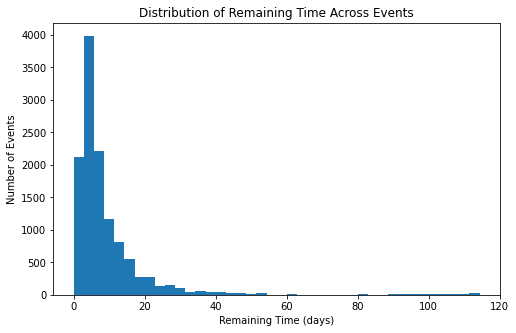

In [126]:
# distribution of remaining time across events. 
plt.figure(figsize=(8,5))
plt.hist(df['remaining_time(days)'], bins=40)
plt.xlabel("Remaining Time (days)")
plt.ylabel("Number of Events")
plt.title("Distribution of Remaining Time Across Events")
plt.show()

### Figure 2 — Frequency of Activities in the Sepsis Log

This bar chart shows how often each activity appears in the event log. A few activities (like Leucocytes, CRP, and LacticAcid measurements) occur very frequently, while others are much rarer. This means that most patient traces follow similar diagnostic steps, and a small number of activities only appear in specific situations.

Understanding which activities dominate the process helps us later when we encode traces, since common activities will have a much bigger influence on the model than rare ones.


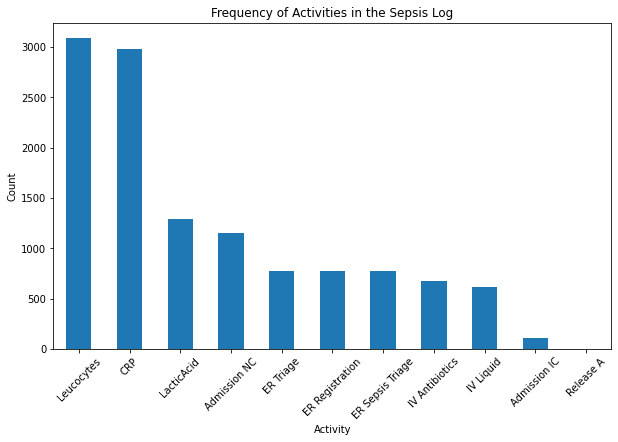

In [127]:
plt.figure(figsize=(10,6))
df['Activity'].value_counts().plot(kind='bar')
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Frequency of Activities in the Sepsis Log")
plt.xticks(rotation=45)
plt.show()

### Figure 3 — Distributions of Numerical Clinical Attributes

These histograms show the distributions of the main numerical clinical measurements: Leucocytes, CRP, and LacticAcid. All three are strongly right-skewed, meaning most values are relatively low, with some patients showing very high values.

This pattern is typical in medical data and suggests that:
- we may want to apply scaling or transformation later, and  
- the extreme values likely reflect real clinical severity rather than noise.

These plots give us a first idea of how these variables behave and how they might contribute to predicting remaining time.


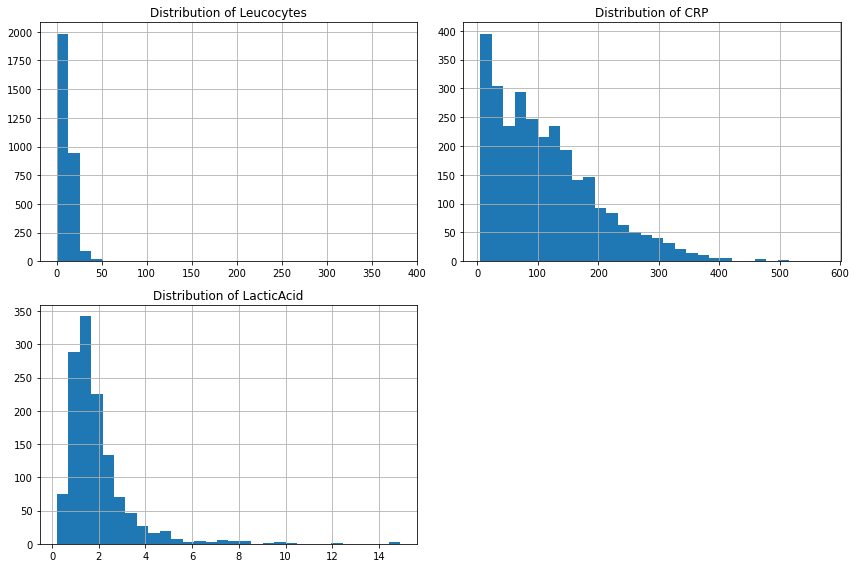

In [128]:
cols = ['Leucocytes', 'CRP', 'LacticAcid']

plt.figure(figsize=(12,8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    df[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

### (Optional) 1.2 Process Discovery and Visualization 

This is an optional task to show you how process discovery and visualizaion can be deployed using the pm4py library. 

(*The following code requires the graphviz library to be installed. If you have issues with installing the graphviz, you may try to follow the instructions on Install GraphViz on the [pm4py](https://pm4py.fit.fraunhofer.de/install-page) install page*)

The following code:
- fill in the columns for case id, activity, and timestamps
- convert the data set into an event log
- discover a Directly-follows graph (DFG) and a process model for each event log. 
- you may use the discovered process model in your report



In [129]:
# If you have brew installed, install graphviz brew install graphviz
# Then install pm4py library and graphviz library using pip install 
# !pip install -U pm4py
# !conda install graphviz
# !conda install python-graphviz
import pm4py


data_Sepsis[column_Sepsis_CaseID] = data_Sepsis[column_Sepsis_CaseID].astype(str)

data_Sepsis_copy = data_Sepsis.copy()
data_Sepsis_copy['Complete Timestamp'] = pd.to_datetime(data_Sepsis_copy['Complete Timestamp'])

# Convert the data to an event log
log_Sepsis = pm4py.format_dataframe(data_Sepsis_copy, case_id=column_Sepsis_CaseID, activity_key=column_Sepsis_Activity, timestamp_key=column_Sepsis_Timestamps)

# Set the log to be the one that you are interested
log = log_Sepsis

# Create a Directly-Follows Graph (DFG) and plot this graph
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

# Discover a Process Model using Inductive Miner and plot this BPMN model
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Task 2: Preprocessing and Trace Encoding

### 2.1 Data preprocessing

In the previous data exploration task, you gathered some initial insights about the dataset. Based on your observations during data exploration, decide which preprocessing steps are necessary (e.g., handling missing values, encoding categorical variables, scaling numerical features, etc.) and implement them accordingly.

### Handling Missing Values

#### Boolean Clinical Test Columns (True / False / NaN)

During exploration, we observed that many clinical indicators (e.g., `InfectionSuspected`, `DiagnosticBlood`, `SIRSCritTemperature`, etc.) contain the values `True`, `False`, and `NaN`. Importantly, the NaN values do **not** represent missing measurements in the traditional sense. Instead, they indicate that **a specific diagnostic test was not performed at that event**. This distinction is clinically meaningful.

For example, a patient might not undergo a lactic acid test early in their trajectory, and the absence of this test is informative: it often correlates with clinical stability. Because of this, we cannot impute NaN values with True/False, nor can we drop the rows.

**Decision:**  
Treat these variables as **categorical features with three states**:

- `0` = False (test performed and negative/normal)  
- `1` = True  (test performed and positive/abnormal)  
- `2` = Not performed (originally NaN)

This encoding preserves the semantic meaning of the missing values and makes the features usable for downstream modeling.

**Justification from EDA:**  
Plots and unique-value summaries clearly showed that NaN values dominate several clinical test columns. Treating them as an informative category rather than noise ensures that the model can learn the difference between “test not performed” and “test performed but normal.”


In [138]:
df_pre = df.copy()

In [139]:
# step 1: preprocessing the boolean like columns
bool_like_cols = [
    'InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea',
    'Hypotensie', 'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup',
    'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther',
    'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature',
    'DiagnosticUrinaryCulture', 'SIRSCritLeucos', 'Oligurie',
    'DiagnosticLacticAcid', 'Hypoxie', 'DiagnosticUrinarySediment',
    'DiagnosticECG'
]

In [140]:
# columns above are replaced by integers: True = 1, False = 0 and NaN = 2
df_pre[bool_like_cols] = (
    df_pre[bool_like_cols]
    .fillna(2)
    .replace({False: 0, True: 1})
)

In [174]:
df_pre["Leucocytes"].median()

10.9

#### Numerical Clinical Measurements (Age, Leucocytes, CRP, LacticAcid)

These four variables were the only continuous numerical features in the dataset. The visualizations in Task 1 showed that all of them are **heavily right-skewed with extreme outliers**, which is expected in medical data.

Missing values in these columns represent the **absence of a recorded measurement**, not a meaningful category. For instance, not every patient has a CRP or lactate value associated with every event.

**Decision:**  
Impute missing values using the **median** of each column.

**Why median instead of mean?**

- Median is robust to outliers, which are very common in sepsis (e.g., extremely high CRP or lactate levels).
- Imputing with the mean would artificially inflate the values due to skewness.
- Median imputation preserves the general distribution without distorting the feature space.

**Justification from EDA:**  
Histograms of Leucocytes, CRP, and Lactic Acid revealed long right tails. Median imputation is therefore the most stable and statistically appropriate choice.


In [133]:
numeric_cols = ['Leucocytes', 'CRP', 'LacticAcid']

for col in numeric_cols:
    df_pre[col] = df_pre[col].fillna(df_pre[col].median())

#### Dropping columns

During exploration, we found that the `Diagnose` column contains categorical codes such as A/B/C and also NaN values. However:

- This diagnosis is assigned **after the process has completed**.
- It would not be known at prediction time.
- Including it would introduce **label leakage** and artificially improved model performance.

The column `lifecycle:transition` contains the element: `complete`. This feature carries zero variance and adds no predictive value.

The column `Complete Timestamp` contains the raw data format of a timestamp. The timestamp has already been converted into usefull forms. 

**Decision:**  
Drop `Diagnose`, `lifecycle:transition` and `Complete Timestamp` columns entirely.

**Justification:**  
The columns Complete Timestamp and lifecycle:transition were removed because they do not contribute any meaningful information to the prediction task. The lifecycle:transition attribute contains only a single value (“complete”) for all events, which means it provides no variance and cannot support learning. Likewise, the raw Complete Timestamp cannot be used directly as a predictive feature because absolute calendar dates carry no semantic meaning for case progression and may introduce unwanted noise or leakage. All necessary temporal information (such as remaining time and event ordering) has already been extracted into derived features.

In [142]:
df_pre = df_pre.drop(columns=["Diagnose", "Complete Timestamp", "lifecycle:transition"], axis=1)

In [136]:
# TODO: decide on how you handle missing values (ranging from dropping columns and dropping rows to filling in the empty cells)


# TODO: perform data preprocessing steps 



### 2.2 Trace Encoding


- Implement the aggregation encoding for the data set (for example, see [1], Table 6)

<span style="color:gray">[1] Ilya Verenich, Marlon Dumas, Marcello La Rosa, Fabrizio Maria Maggi, Irene Teinemaa:
Survey and Cross-benchmark Comparison of Remaining Time Prediction Methods in Business Process Monitoring. ACM Trans. Intell. Syst. Technol. 10(4): 34:1-34:34 (2019) [Section 1, 2, 4.1, 4.3, 4.6, 5.2, 5.3, 5.4, and 6] </span>

This encoding has been discussed during lecture 7.
- for the aggregation encoding check the pandas groupby.DataFrameGroupBy and cumsum function and read the [examples and answers on the stake overflow](https://stackoverflow.com/a/49578219)

In [137]:


# TODO: Implement the function that returns the aggregation state encoding of a log
def agg_per_event_encoding(dataFrame, columnCase, columnActivity):
    _new_data = dataFrame.copy()
    
    # TODO: Apply one-hot encoding to the 'activity' column
    onehot = ...
    
    # TODO: Group by 'case id' and compute the cumulative sum for each activity
    cumulative_freq = ...
    
    # TODO: Concatenate the original DataFrame with the cumulative frequencies
    _data_with_features = pd.concat([_new_data, cumulative_freq], axis=1)
    
    return(_data_with_features)



# For the data set, apply the aggregated state encoding
data_Sepsis_ag = ls_encoding(df, column_Sepsis_CaseID, column_Sepsis_Activity)
print(data_Sepsis_ag)

NameError: name 'ls_encoding' is not defined

### 2.3 Create training and test data sets using temporal split


Choose the size of your test data and use that to find the appropiate date (time threshold) to split the dataset into training  and test set.

This approach is commonly used for time-series or event log data to ensure that training data comes from earlier time periods and test data from later periods. This avoids data leakage, where future data might influence the training process.

When writing your report, explain how you split the data and provide a justification for your choice as part of the experiment setup discussion.

In [ ]:

# Define time threshold
time_threshold = pd.Timestamp('2014-09-30 00:00:00')

# Split the case 
def train_test_time_based_split(data_frame, time_threshold, column_case_id, column_activity, column_time_stamp, column_label):
    # TODO: Identify the start time of each case
    
    
    # TODO: Separate case IDs into training and test sets
    
    # TODO: Assign rows to training and test sets based on case IDs

    # TODO : Create the training and test sets, while dropping the irrelevant columns 
    X_train = ...
    y_train = ...
    
    X_test = ...
    y_test = ...
    return (X_train, X_test, y_train, y_test)



X_train, X_test, y_train, y_test = train_test_time_based_split(
    data_Sepsis_ag, time_threshold, column_Sepsis_CaseID, 
    column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

## Task 3: Predicting Case Remaining Time 


In this task, you will train a regression model (aka regressor) to predict case remaining time. 
You may choose the regression tree, the random forest regression, the kNN-regressor, or the MLP for regression. Very similar to how you have trained a classification model in Assignment 1, now perform the following steps to train a regression model. 

A) use the default values for the parameters to get a regressor on the training data. 
- [Regression Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

(OPTIONAL) use 5-fold cross-validation to tune the parameters. And create plots to show how the selected parameters affect the performance. 

B) select the best-performing regressor (e.g., the default one or the one that achieved the lowest error) and report the error measures (MAE, MSE, RMSE, R^2) of the fitted model on the test data. 

    
#### TIPS:
In case you decide to perform cross-validation, you are allowed to reuse some of your code from Assignment 1 or use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class (see an [example](https://www.dezyre.com/recipes/find-optimal-parameters-using-gridsearchcv-for-regression), but be aware that GridSearchSV does not return MAE or the other error measures (e.g., MSE, RMSE, R^2), you will need to update the scoring function)



In [ ]:
# TODO: import packages


# TODO: Train a regression model (e.g., Random Forest Regressor)


# TODO: Evaluate the regressor on the test data and print the errors


## Task 4. Create three buckets and repeat Tasks 2 and 3 for each bucket. 

In this task, you will create three buckets, for prefix length 5, 10 and 15. For each of the bucket, repeat Task 2 and 3.  

You may use the functions you built for Tasks 2 and 3 or reuse code. 

Calculate the error measures (MAE, MSE, RMSE, R^2) and discuss the results. 

In [ ]:
# TODO: import packages


# Group by case_id and create a prefix column
df['prefix'] = df.groupby(column_Sepsis_CaseID).cumcount() + 1

# Buckets for prefix lengths 5, 10, and 15
buckets = {5: [], 10: [], 15:[]}

# TODO: Populate the buckets
for prefix_length in buckets.keys():
    # TODO: Populate the bucket with the events that have prefix <= prefix_length
    ...

# Create a regressor for each bucket    
regressors = {}


for prefix_length, bucket_df in buckets.items():
    if not bucket_df.empty:
        
        # TODO: Apply the encoding
        bucket_df_Sepsis_ag = agg_per_event_encoding(bucket_df, column_Sepsis_CaseID, column_Sepsis_Activity)
        
        # TODO: Retain the event of prefix_length
        bucket_df_Sepsis_ag = bucket_df_Sepsis_ag[bucket_df_Sepsis_ag['prefix'] == prefix_length]
       
        # TODO: Create train-test split
        X_train, X_test, y_train, y_test = train_test_time_based_split(
            bucket_df_Sepsis_ag, time_threshold, column_Sepsis_CaseID, 
            column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

        # TODO: Train a regression model (e.g., Random Forest Regressor)


        # TODO: Evaluate the regressor by calculating the MAE, etc...

        # TODO: Store/print your results

        # Store the trained regressor
        regressors[prefix_length] = reg


## Task 5. Two Alternative Preprocessing and Encoding Methods

In this task, you will refine the design of your method so far and compare the performance of different preprocessing and encoding methods. **Choose two of the following options**:

A) If you have dropped all features except the *activities* in Task 2, select a few features (e.g., Age, Leukocytes, CRP, Lactic Acid), encode them, and repeat Tasks 2 and 3. Motivate your selection in your report. 

B) If you already included some features in Task 2, drop all features except the encoded *activities*, and repeat Task 3.

C) Engineer a feature called *elapsed time* by computing the time elapsed since the case started until the current event, and repeat Tasks 2 and 3. Evaluate if adding this feature (*elapsed time*) help improve the model performance. 

D) Use *last-state encoding* instead of aggregation encoding, and repeat Tasks 2 and 3. Evaluate if the *last-state encoding* help improve the model performance. 


## Task 6.  Report your results and discuss your findings

By now, you have trained and applied a regressor and evaluated its performance on 
(1) the non-bucketed training and test set with all possible prefix length. 
(2) three buckets of different prefix length. 
(3 & 4) and two other methods you tried (e.g., a different encoding or with additional features). 

You have created tables or figures which you can add to your report. 

Create an overview table or figure that compares the performance of each method on the data set, for example, see the table here below. 


Discuss your findings and reflect on the following questions in your report:
- According to the error measures, which one would you suggest as the optimal method (preprocessing + encoding + algorithm)? 
- Are there any discrepancies between the MAE, MSE, RMSE, and R^2 measures in terms of which model/method performs the best? If yes, how would you explain these discrepancies. 
- Which one of the MAE, MSE, RMSE, and R^2 would you use for selecting the model? Why?
- Which one of the encoding would you suggest for this data set? Why?
- Which features have a big influence on predicting the remaining time?





| Encoding | Model | Training MAE  | Test MAE |  Training MSE  |  Test MSE  | Training R^2 | Test R^2 |... |
|------|------|------|------|------|------|------|------|-----|
|  Agg-state and no bucketing |  RF regressor |  |  | || | |
|  Agg-state and prefix length 5 |RF regressor       |  |  | || | |
|   Agg-state and prefix length 10 |RF regressor     |  |  | || | |
|   Agg-state and prefix length 15 |RF regressor     |  |  | || | |
|   last-state |RF regressor    |  |  | || | |
|   last-state + additional features |RF regressor    |  |  | || | |












## Bonus Tasks 

We would like to challenge you with the following bonus tasks. For each task that is successfully completed, you may obtain max. 0.5 extra point added to the total 14 points. 

1. Train a MLP for regression. (If you have used MLP for Task 3, then train another regressor of interest. Evaluate the performance. Explain this in your report.)
2. Train an Autoencoder for feature reduction/learning and evaluate whether it helps improve the performance. Explain this in your report.

